## One shot learning using siamese convolutional neural networks

Deep neural networks are able to perform very well on tasks such as classification when given large amounts of data (and trained properly offcourse). It becomes very hard to train these deep neural networks with millions of parameters with the scarse data. So I find it very exciting as to how DNN's can be trained to solve the learning tasks when data is scarse. In this notebook we will be looking to solve the classification problem on the omniglot dataset. The omniglot dataset contains only 20 samples per character (class) and every alphabet (language) contains multiple characters (classes). 
The data is divided into 2 parts.
* Background (Used for training)
* Evaluation (Used for validation and testing)

The approach I have taken to solve this problem is using siamese networks as proposed by Koch,Zemel and Salakhutdinov.
[\[1\]](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).    

In [1]:
import random
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn.metrics import accuracy_score

### Load background data
open the background data from the github url (link) and read the entire folder in bytes format.

In [2]:
background_url = 'https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip?raw=true'
resp = urlopen(background_url)
background_folder = ZipFile(BytesIO(resp.read()))

### Data exploration

In the below section we explore some details related to the background data. The data_summary() function described below prints information regarding the the omniglot data. this function is again called latter when loading the omniglot evaluation data.
The data_summary() function prints the following information. 
* number of unique characters in the the background set. 
* Number of alphabets in the background set. 
* List some of the names of the alphabets
* Find out the size of a random image
* Display a random image
* Print path of a file in the background data

In [3]:
def load_image(file_name,zip_folder):
    """
    Loads  a single image file as a numpy array.
    Args:
        file_name: path of the image file
        zip_folder: path of the zipped image folder containing the image file
    Returns:
        img: 2-d numpy array representing the image
    """
    file = zip_folder.open(file_name)
    img = mpimg.imread(file)
    return img

def data_summary(zip_folder):
    """
    Prints summary of the omniglot data. (for background and evaluation folders)
    Args:
        zip_folder: path of the zipped image folder containing the image file
    Returns:
        images_path_list: the list of paths for the images 
        alphabets: A set() containing the names of the alphabets in the data folder
    """
    alphabets = set()
    unique_characters = set()
    images_path_list = list()
    for names in zip_folder.namelist():
        if names.endswith('.png'):
            _,alphabet,_,image_name = names.split('/')
            alphabets.add(alphabet)
            unique_characters.add(image_name.split('.')[0].split('_')[0])
            images_path_list.append(names)

    print("Total number of unique alphabets (languages): ",len(alphabets))
    print("Names of some of the random unique alphabets: \n", random.sample(alphabets,7))
    print("Total number of unique characters (classes) : ",len(unique_characters))
    img_path = random.sample(images_path_list,1)[0]
    print("Path of one of the images: ",img_path)
    img = load_image(img_path,zip_folder)
    print("Shape of the sample image :",img.shape)

    
    
    return images_path_list,alphabets

In [4]:
background_path_list,background_alphabets = data_summary(background_folder)

Total number of unique alphabets (languages):  30
Names of some of the random unique alphabets: 
 ['Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Bengali', 'Grantha', 'Mkhedruli_(Georgian)', 'Hebrew', 'Sanskrit', 'Braille']
Total number of unique characters (classes) :  964
Path of one of the images:  images_background/Alphabet_of_the_Magi/character04/0712_13.png
Shape of the sample image : (105, 105)


## Data Visualization

In the below section we visualize some of the characters for the alphabets in the background set. The section contains 4 functions:
* set_title(): Set the title of the subplot
* image_subplot(): plot the subplot contains either 1 or multiple images
* visualize(): calls subplot and set title to build the entire plot accordingly
* visualize_data(): used to visualize alphabets in the background and evaluation datasets. (Uses visualize())

visualize() function is used multiple times in the notebook for data visualization. 
Below we can visualize some of the random characters for some random alphabets in the background set. The visualize_data() is used to visualize the data prepared for the verfication task (training and validation). From visualizing the images we can conclude we do not require to normalize the images in any way as they are binary images.

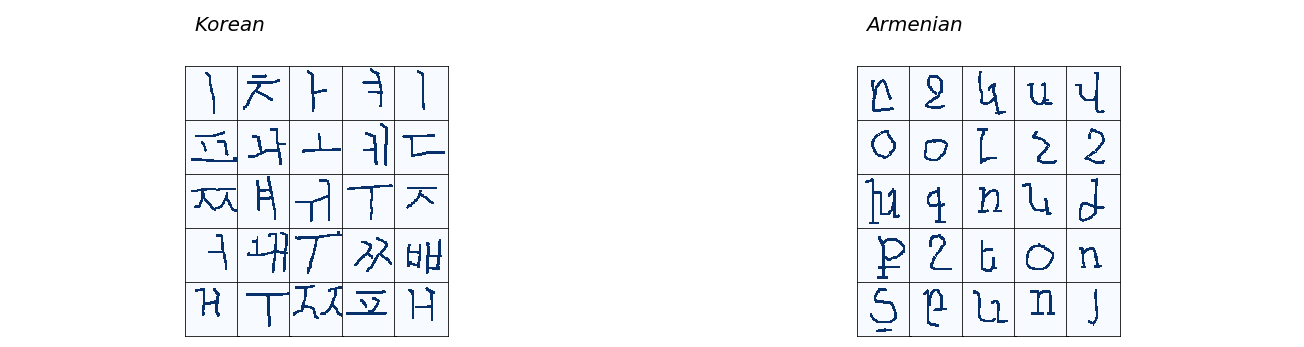

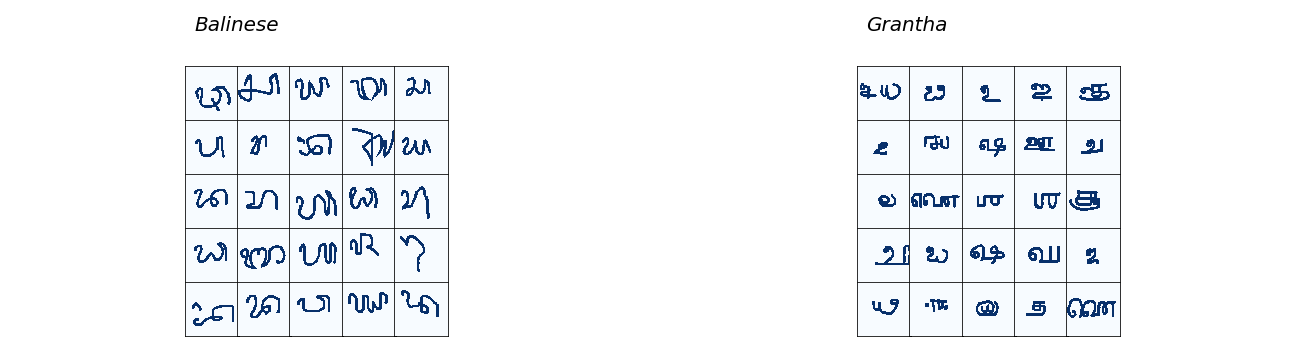

In [5]:
def set_title(fig,outer,text):
    """
    Sets the title for the 2 grids of the figure.
    Args:
        figure: figure object on which the plots are formed.
        outer: path of the zipped image folder containing the image file
        text: text iterator object which is called by next()
    Returns:
        figure: the figure object on which text is printed
    """
    for n in range(2):    # as there are two inner grids (subplots) set iter 2 times.
        ax = plt.Subplot(fig,outer[0,n])
        ax.text(0.3, 0.5, next(text), style='italic',fontsize=20) # call next on text iter object and add text.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        fig.add_subplot(ax)
    
    return fig

def image_subplot(numImages,inner,img_paths_iter,fig,prediction=None):
    """
    Plot the images onto the figure.
    Args:
        numImages: total number of images to be plotted in the figure
        inner: path of the zipped image folder containing the image file
        img_paths_iter: iterator object containing paths of the images which nead to be read and plotted.
        fig: the figure object on which the images are plot.
        prediction: index of the predicted image in the subplot (only used at the end of the notebook 
        for showing the siamese network predictions)
    Returns:
        figure: return the figure object
    """
    for i in range(numImages):    
        ax = plt.Subplot(fig, inner[i])
        if i != prediction:  # prediction kept None for most call only used at end to highlight the prediction image.
            ax.imshow(next(img_paths_iter),cmap='Blues_r')  # call next on img path iter object and plot image
        else:
            ax.imshow(next(img_paths_iter),cmap='Greens')   # call next on img path iter object and plot image
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        
    return fig
    

def visualize_images(figsize,text,inner1dim1,inner1dim2,inner2dim1,inner2dim2,img_paths_iter,wspace,prediction=None):
    """
    transforms the figure into a grid structure. having 3 grid objects outer,inner1,inner2. the text and 
    images are plotted on these 3 grid structures.
    Args:
        figsize: tuple which represents the widh (w) and height (h) of the figure
        text: the text to be displayed on the figure.
        inner1dim1: the number of horizontal partitions for the inner1 grid.
        inner1dim2: the number of vertical partitions for the inner1 grid.
        inner2dim1: the number of horizontal partitions for the inner2 grid.
        inner2dim2: the number of vertical partitions for the inner2 grid.
        img_paths_iter: iterator containing the image paths used by image_subplot() function
        wspace: wide space between the images in the subplot 
        prediction: Used at the end of the notebook to highlight some predictions of the siamese network.
    Returns:
        None
    """
    
    fig = plt.figure(figsize=figsize)
    
    # divide the figure into subplot grids for plotting.
    outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1,width_ratios=[1, 1], height_ratios=[0.15, 1])
    
    inner1 = gridspec.GridSpecFromSubplotSpec(inner1dim1,inner1dim2,
                        subplot_spec=outer[1,0], wspace=wspace, hspace=0.0)
        
    inner2 = gridspec.GridSpecFromSubplotSpec(inner2dim1,inner2dim2,
                subplot_spec=outer[1,1], wspace=wspace, hspace=0.0)    
    
    # set title for the figure (uses outer grid).
    set_title(fig,outer,text)
    
    # plot figures on the figure (uses inner1,inner2 grids)
    fig = image_subplot(inner1dim1*inner1dim2,inner1,img_paths_iter,fig,None)
    fig = image_subplot(inner2dim1*inner2dim2,inner2,img_paths_iter,fig,prediction)
    
    # display
    plt.show()
    

def visualize_data(alphabets,path_list,folder):
    """
    visualize 25 random characters for 4 random alphabets for (background and evaluation data). 
    Calls the visualize image to transform the plot into grids and plot characters accordingly.
    Selects 4 random alphabets and then selects 25 random character for those 4 alphabets
    Args:
        alphabets: the list of unique alphabets generated from data_summary()
        path_list: path of the zipped image folder containing the image file
        folder: zip folder containing path of all the images in the folder. 
    Returns:
        None
    """
    # sample 4 random alphabets
    alphabet_samples = random.sample(alphabets,4)
    # for each sample map to empty list which would store the paths of the images of the alphabet
    sample_paths = {alphabet : [] for alphabet in alphabet_samples}
    visualize_paths = []
    
    # populate the list (storing paths of the characters for the alphabet) for each alphabet
    for image_path in path_list:
        _,alphabet,_,image_name = image_path.split('/')
        if alphabet in sample_paths:
            sample_paths[alphabet].append(image_path)

    images = [] # images which would be visualized
    labels  = [] # alphabet list (used in set title)
    
    # traverse dictionary and select 25 random characters for each alphabet.
    for alphabet,image_paths in sample_paths.items():
        labels.append(alphabet)
        for random_path in random.sample(image_paths,25):
            images.append(load_image(random_path,folder))
       
    # create iterator objects 
    images_iter = iter(images) # used in img_subplots
    label_iter = iter(labels) # used in set_title()

    
    for _ in range(2): # iterate twice 
        
        # plots characters of two alphabets horizontally (hence for four alphabets called twice.)
        visualize_images(figsize=(23,6),
                  text=label_iter,
                  inner1dim1=5,
                  inner1dim2=5,
                  inner2dim1=5,
                  inner2dim2=5,
                  img_paths_iter=images_iter,
                  wspace=-0.87)
        

# visualize the background data.
visualize_data(background_alphabets,background_path_list,background_folder)

### Data Preparation (background set)

In this section we prepare the training data for the verifitcation task. Unlike standard classification tasks where we train a network on input and label pairs and test the models prediction performance on the test input and output pairs. In one shot learning as there is scarse data we try to learn a similarity function between the inputs hence the input to the network is a pair of images and the siamese network learns a mapping function which maps the pair of inputs to either similar/positive pair (1) or dissimilar/negative pair (0). The data for the one-shot learning verification task can be formally described as follows:

$$ X_{train} =  \{({x_{l}}^1,{x_{r}}^1),({x_{l}}^2,{x_{r}}^2)...({x_{l}}^n,{x_{r}}^n)\}  $$

$$ {x_l}^i \in \mathbb{R}^{105 \times 105 \times 1} \;\; $$

$$ {x_r}^i \in \mathbb{R}^{105 \times 105 \times 1} $$

$$ Y_{train} =  \{{y}^1,{y}^2...,{y}^n\}  $$

$$ {y}^i \in \{0,1\} $$

$ x_l $ presents the left image passed to the network. and $ x_r $ represents the right image passed to the network. $ y $ represents the label 0 or 1 for the pair of $ x_l,x_r.$  $ n $ represents the number of samples in the data. The data preparation follows the same procedure as given in the paper [\[1\]](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). For every alphabet in the background set random characters are chosen and paired within the character sample space and labelled as 1 (positve pair) and then paired with an image outside the character and the pair is labelled 0 (negative pair). Similar to the paper I have chosen to uniformly sample (positive and negative) pairs from the alphabets. For each alphabet there are 1000 pairs of images (500 positive and 500 negative). As there are 30 alphabets in the bacground set. There are a total of 30000 (30 * 1000) samples for the training. Hence X_train consists of 30000 samples and Y_train contains 30000 labels for the corresponding pair in X_train. The paper uses a much larger set of 150,000. I assume 5000 samples per alphabet. To prepare the data for the task a tree structure is created where the dictionary contains the alphabets containing the characters which then map to paths of images for those characters.

In [6]:
def print_structure(alphabetMap):
    """
    prints the tree structure of the alphabetMap.
    Args:
        alphabetMap: A nested dictionary representing a tree data structure.
    Returns:
        None
    """
    print("one of the brances of the tree")
    for alphabet,characterMap in alphabetMap.items():
        print(alphabet)
        print("|\n|")
        for character,character_list in characterMap.items():
            print("--> Character {0} \n\t\t|\n\t\t|".format(character))
            for i in range(5):
                print("\t\t|---> " + character_list[i])
            print("\t\t.\n\t\t.\n\t\t|---> " + character_list[-1])
            break
        break
        
def generate(alphabetMap):
    """
    Generates the X_data and Y_data for (training/validation).
    Args:
        alphabetMap: A nested dictionary representing a tree data structure.
    Returns:
        X_data: list of tuples containing paths of the left,right images.
        Y_data: list of 0/1 labels 
    """
    X_data = []
    Y_data = []
    seen = set()
    for alpha,characters in alphabetMap.items():
        index = 0
        while index != 500:  # every alphabet has 500 positive and 500 negative samples.
            c, nc = random.sample(list(characters),2)
            a1,a2 = random.sample(characters[c],2)
            if (a1,a2) in seen or (a2,a1) in seen: # check is pair already in data.
                continue
            a3 = random.sample(characters[nc],1)[0]
            if (a1,a3) in seen or (a3,a1) in seen:
                continue

            X_data.append([a1]+[a2]) # add positive pair
            Y_data.append(1)
            X_data.append([a1]+[a3]) # add negative pair
            Y_data.append(0)
            seen.add((a1,a2))
            seen.add((a1,a3))
            index += 1

    return X_data,Y_data

def data_preparation(images_path_list,visualize=False):
    """
    Creates the tree structure for samples pairs and then calls the generate function to generate sample pairs and labels.
    Also calls visualize (optional) for viewing the tree structure from where the data is 
    Args:
        images_path_list: the list of path of all images in the zip folder data.
        visualize: visualize the tree structure of the alphabet map.
    Returns:
        X: A list of tuple containing image paths of pair of images (X_left,X_right)
        Y: A list of 1s and 0s. 1 for positive pair and 0 for negative pair.
    """
    alphabetMap = dict() # define the tree 
    
    # for all image paths map every alphabet to a list of all the characters of the alphabet.
    # and every character to the 20 img paths of the character.
    for image_path in images_path_list:
        _,alphabet,_,image_name = image_path.split('/')
        if alphabet not in alphabetMap:
            alphabetMap[alphabet] = dict()    
        char = image_name.split('_')[0] 
        alphabetMap[alphabet].setdefault(char,[]).extend([image_path])
    
    if visualize: print_structure(alphabetMap) # visualize the tree structure
    
    return generate(alphabetMap) # generate the training\validation from the tree.

In [7]:
X_train, Y_train = data_preparation(background_path_list,visualize=True)
assert len(X_train) == len(Y_train),"data not prepared properly"

print("\n(training) Number of samples in X_train : {}".format(len(X_train)))
print("(training) Number of labels in Y_train : {}".format(len(Y_train)))
index = random.sample([i for i in range(0,len(X_train),2)],1)[0]
print("path of a left image of a positive training sample:",X_train[index][0])
print("path of a right image of the same positive training sample:",X_train[index][1])
print("label of the training sample:",Y_train[index])
print("path of a left image of a negative training sample:",X_train[index+1][0])
print("path of a right image of the same negative training sample:",X_train[index+1][1])
print("label of the training sample:",Y_train[index+1])

one of the brances of the tree
Gujarati
|
|
--> Character 0430 
		|
		|
		|---> images_background/Gujarati/character13/0430_01.png
		|---> images_background/Gujarati/character13/0430_02.png
		|---> images_background/Gujarati/character13/0430_03.png
		|---> images_background/Gujarati/character13/0430_04.png
		|---> images_background/Gujarati/character13/0430_05.png
		.
		.
		|---> images_background/Gujarati/character13/0430_20.png

(training) Number of samples in X_train : 30000
(training) Number of labels in Y_train : 30000
path of a left image of a positive training sample: images_background/Anglo-Saxon_Futhorc/character09/0304_07.png
path of a right image of the same positive training sample: images_background/Anglo-Saxon_Futhorc/character09/0304_16.png
label of the training sample: 1
path of a left image of a negative training sample: images_background/Anglo-Saxon_Futhorc/character09/0304_07.png
path of a right image of the same negative training sample: images_background/Anglo-Saxo

### Visualization for the verfication task (training set)


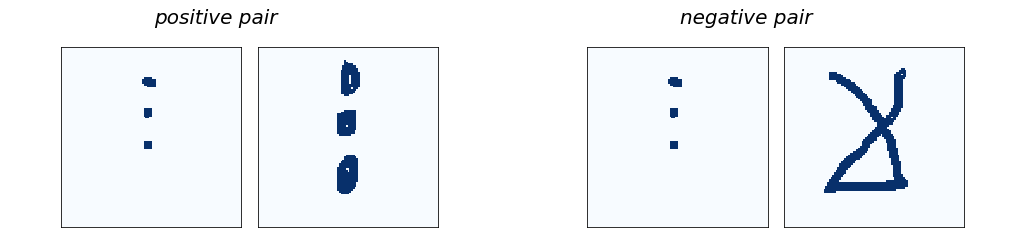

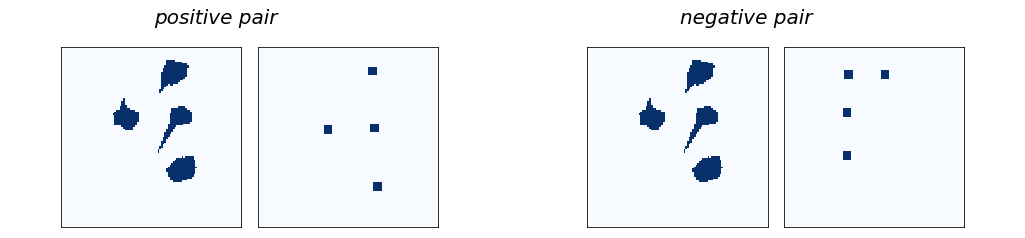

In [8]:
def visualize_verification(X,folder):
    """
    visualize the verfication task of (background/validation)
    Args:
        X: A list of tuples containing the paths of the pairs of the images.
        folder: the zip folder object used to read and load the images.
    Returns:
        None
    """
    for _ in range(2): # 1 figure has two subplots. to plot 2 figures (4 pairs) called 2 times. 

        index = random.sample([i for i in range(0,len(X),2)],1)[0]  # randomly select an even positioned pair (postive)
        img_paths = []
        img_paths.append(load_image(X[index][0],folder)) # load the left image for the even index postion
        img_paths.append(load_image(X[index][1],folder)) # load the right image for the even..
        img_paths.append(load_image(X[index+1][0],folder)) # load the left ... for the odd index position (negative pair)
        img_paths.append(load_image(X[index+1][1],folder)) # load the right ... for the odd index position

        img_paths_iter = iter(img_paths)
        text = iter(['positive pair','negative pair'] * 2)

        # call the visualize images defined above.
        visualize_images(figsize=(18,4),
                         text=text,
                         inner1dim1=1,
                         inner1dim2=2,
                         inner2dim1=1,
                         inner2dim2=2,
                         img_paths_iter=img_paths_iter,
                         wspace=-0.3)

visualize_verification(X_train,background_folder)

### Loading evaluation set and generating summary 
open the evalution data from the github url (link) and read the entire folder in bytes format.

In [9]:
eval_url = 'https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip?raw=true'
resp = urlopen(eval_url)
eval_folder = ZipFile(BytesIO(resp.read()))

eval_path_list, eval_alphabets = data_summary(eval_folder)

Total number of unique alphabets (languages):  20
Names of some of the random unique alphabets: 
 ['Angelic', 'Sylheti', 'Mongolian', 'Oriya', 'Kannada', 'Old_Church_Slavonic_(Cyrillic)', 'Manipuri']
Total number of unique characters (classes) :  659
Path of one of the images:  images_evaluation/Glagolitic/character31/1145_13.png
Shape of the sample image : (105, 105)


### Visualization (evalution set)

visualizing some random character samples belonging to some random alphabets in the evalution set.

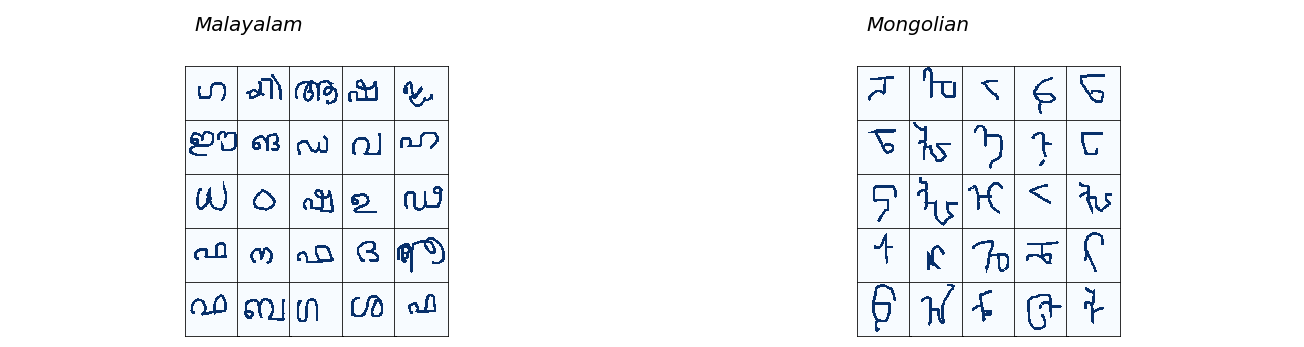

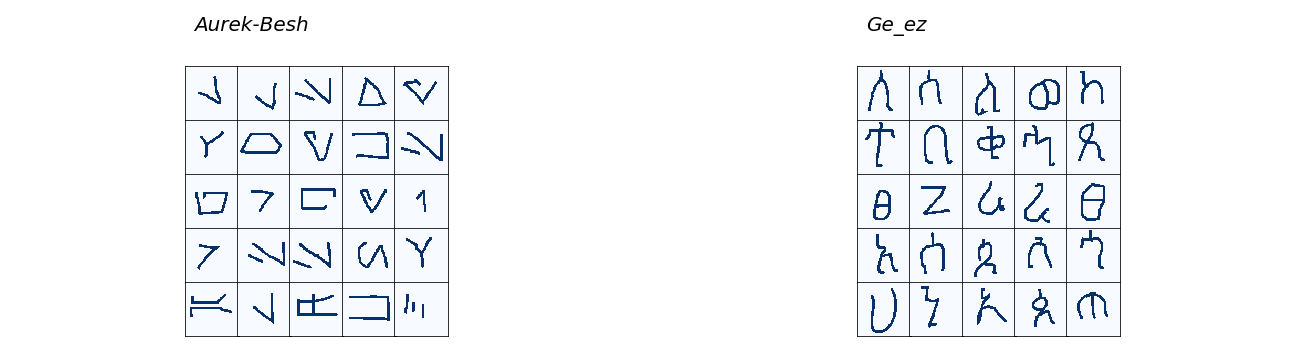

In [10]:
visualize_data(eval_alphabets,eval_path_list,eval_folder)

### Data Preparation (validation and test split)
In the below section we split the evaluation set into two lists for validation data and testing data. The same procedure is followed as listed in the paper. The evaluation data is divided into two parts for validation and for 20 way one shot testing. The evaluation data contains 20 alphabets. The first 10 alphabets are used as the validation set for the one shot verification task and the remaining last 10 alphabets are used for creating the 20 way one shot testing trials as presented in the paper. The only difference is that I have decided to keep my validation set for the verification similar to how the training set is represented ((x_l,x_r) sample pair and (y) label). But In the paper they have used 320 one shot trials which mimic the 20-way one shot testing. The paper also consider my approach and there is little difference. Hence I went ahead with generating the validation set having the same structure as the training set. **Note: None of the alphabets (or characters) are shared between the training, validation and testing sets. All the sets have completely different classes and are mutually exclusive.** 

In [11]:
seen = set()
validation_paths = []
testing_paths = []
for image_path in eval_path_list:
    _,alphabet,_,image_name = image_path.split('/')
    seen.add(alphabet)
    if len(seen) <= 10:
        validation_paths.append(image_path)
    else:
        testing_paths.append(image_path)
        
X_val, Y_val = data_preparation(validation_paths)

assert len(X_val) == len(Y_val),"data not prepared properly"
print("\n(validation) Number of X samples: {}".format(len(X_val)))
print("(validation) Number of Y samples: {}".format(len(Y_val)))
index = random.sample([i for i in range(0,len(X_val),2)],1)[0]
print("path of a left image of a positive validation sample:",X_val[index][0])
print("path of a right image of the same positive validation sample:",X_val[index][1])
print("label of the validation sample:",Y_val[index])
print("path of a left image of a negative validation sample:",X_val[index+1][0])
print("path of a right image of the same negative validatoin sample:",X_val[index+1][1])
print("label of the validation sample:",Y_val[index+1])


(validation) Number of X samples: 10000
(validation) Number of Y samples: 10000
path of a left image of a positive validation sample: images_evaluation/Gurmukhi/character38/1197_10.png
path of a right image of the same positive validation sample: images_evaluation/Gurmukhi/character38/1197_05.png
label of the validation sample: 1
path of a left image of a negative validation sample: images_evaluation/Gurmukhi/character38/1197_10.png
path of a right image of the same negative validatoin sample: images_evaluation/Gurmukhi/character12/1171_17.png
label of the validation sample: 0


### Visualization for the verfication task (validation set)

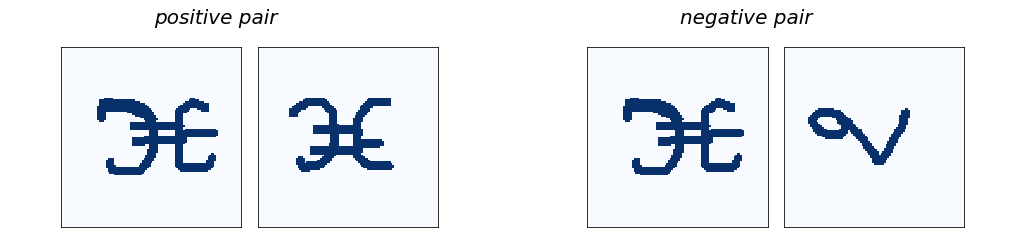

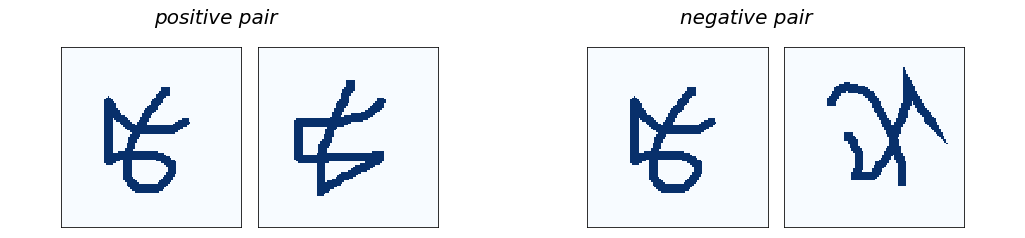

In [12]:
visualize_verification(X_val,eval_folder)

### Data preparation one shot testing 20-way classification (testing)

As of now we have prepared the training data (from background set) having 30,000 samples and validation data (from evaluation set) having 10,000 samples. For the testing the 20 way classification. The same approach is used as in the paper to create a test data from the evaluation set. The approach follows by selecting the first alphabet along with 20 random characters in the alphabet. Then two drawers are selected at random. the first drawers 20 characters are chosen as the test images and tested against the same 20 characters of the 2nd drawer. Only one character from the 2nd drawer would represent the test character from the 1st drawer. 
$$ X_{ost} = [x^1, x^2, x^3, ... x^{400}] $$
$$ x = [test, sample_1, sample_2, ... sample_{20}] $$
$$ Y_{ost} = [y^1, y^2, y^3, ... y^{400}] $$
$$ y = \{ i  |  0 <= i < 20\} $$
$ X_{ost} $ represents the entire one shot test data and $ x $ repsents as sample trial.
$ Y_{ost} $ represents the labels for the one shot test data. $ y $  presents the index (label) corresponding to the correct pair in $ x $.

In [13]:
#initialize an alphabet map
alphabetMap = {}
#drawerSet a set containing names of drawers 
drawerSet = set()

# below loop creates the tree similar to above

# iterate through the testing files paths
for image_path in testing_paths:
    _,alphabet,_,image_name = image_path.split('/')
    # add alphabet to the alphabetMap mapping to a dictionary
    if alphabet not in alphabetMap:
        alphabetMap[alphabet] = dict()
    
    char,drawer_tag = image_name.split('_')
    # add map alphabet to a list of 
    alphabetMap[alphabet].setdefault(char,[]).extend([image_path])
    drawerSet.add(drawer_tag.split('.')[0])

X_ost = []  # stores a list of one shot trials  
Y_ost = []  # stores actual ground truth labels for the one shot trials.


for alphabet,character_list in alphabetMap.items():
    for _ in range(2):
        selected_chars = random.sample(list(character_list),20)  # select 20 random characters from the alphbabet
        drawer1,drawer2 = random.sample(drawerSet,2) # select 2 random drawers
        test_drawers = [] # stores path of images for the drawer1
        select_drawers = [] # stores path of images for drawer2
        
        # iterate through the images of 20 characters selected
        for char in selected_chars:
            for image_path in character_list[char]:
                sample_drawer = image_path.split('/')[-1].split('.')[0].split('_')[1]
                if sample_drawer == drawer1:
                    test_drawers.append(image_path)  # store if images belongs to drawer 1
                elif sample_drawer == drawer2:
                    select_drawers.append(image_path) # store if images belongs to drawer 2
        
        # for each image in test_drawer map 20 images in select drawer to create a trial.
        for test_drawer in test_drawers:
            trial = [test_drawer]  # first image in trial is the test image
            label = [] # label for the trial
            test_char = test_drawer.split('/')[-1].split('.')[0].split('_')[0]
            for select_drawer in select_drawers:  # append the 20 images to the trial 
                possible_char = select_drawer.split('/')[-1].split('.')[0].split('_')[0]
                trial.append(select_drawer)
                if test_char == possible_char: 
                    label.append(1)
                else:
                    label.append(0)
            
            X_ost.append(trial)
            Y_ost.append(label)

Y_ost = np.argmax(np.array(Y_ost),axis=1)

print("\n(testing) Number of X samples: {}".format(len(X_ost)))
print("(testing) Number of Y samples: {}".format(len(Y_ost)))



(testing) Number of X samples: 400
(testing) Number of Y samples: 400


### Visualizing one shot testing data (20-way classification)

In the below section we randomly sample two one shot trails to check how the testing data is prepared. 
The left side consists of the test image and the right side consists of 20 possible samples classes from which the network has to chose based on which of the 20 characters resembles the test image. All the 20 characters represent different classes of the same alphabet similar to how they developed the testing set in the paper. There are total of 400 one shot 20 way classification as given in the paper

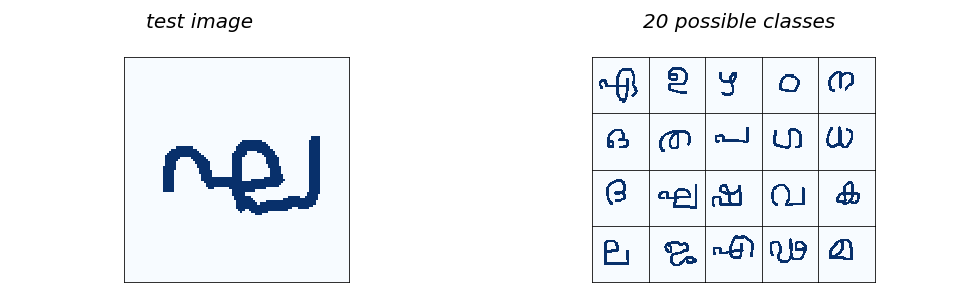

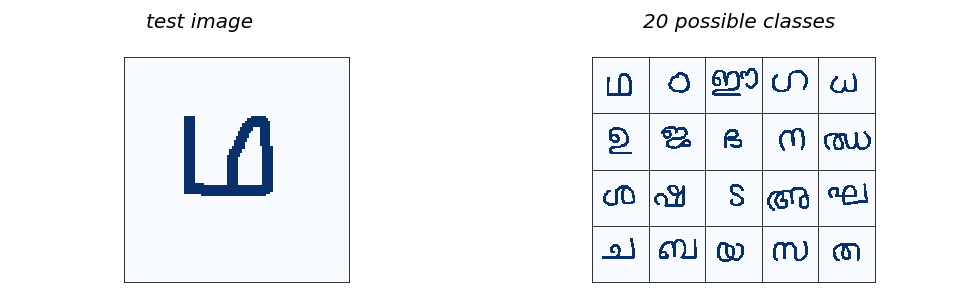

In [14]:
for _ in range(2):  # visualize 2 random one shot trials.
    
    vec = []
    for im in random.sample(X_ost,1)[0]:  # select a random one shot trial
        vec.append(load_image(im,eval_folder))
        
    vec = iter(vec) 
    text = iter(['test image','20 possible classes'])
    
    # visualize a one-shot test trial
    visualize_images(figsize=(17,5),
                     text=text,
                     inner1dim1=1,
                     inner1dim2=1,
                     inner2dim1=4,
                     inner2dim2=5,
                     img_paths_iter=vec,
                     wspace=-0.75) 

## One shot testing trials

I am using the K-Nearest Neighbour algorithm as a baseline to compare it to the one-shot learning algorithm. But as we have only one sample per class in the possible classes that and only one of them is a match to the test sample, Hence the value of K = 1. l2 norm (euclidean distance) is used as the distance metric. Hence for every one-shot trial the distance between the test image and the 20 images (neighbours) is calculated and the class of the image having the closest distance is chosen as the class for the test sample.

### $$ C(x_t) = \underset{c\in C}{\operatorname{argmax}} \lVert x_t - x_c \rVert_2 \;\;\; C = \{0..19\} $$

I am using a baseline algorithm just to get a sense of how well it performs to the one-shot learning siamese network. The reason I have used K-nn is becuase it is simple to implement and works good (better than random guessing and Also becuase the authors of the paper have used it.) The below function is called twice for both the models (1-nn and siamese) on the one shot test data. The below function has the k-nn classifier embedded within it.

In [15]:
# knn
def one_shot_testing(X_ost,Y_ost,model_type,sess=None):
    """
    Tests the performance of the model on the one shot testing data.
    Args:
        X_ost: one shot test trials
        Y_ost: labels of the one shot test trials
        model_type: string either "siamese network" or "knn" to describe which model we want to test
        sess: the tensorflow session used only for model_type == siamese_network.
    Returns:
        Y_pred: array containing predictions of the model.
        accuracy: accuracy of the model.
    """
    Y_pred = []
    for one_shot_trial in X_ost:

        test_image = one_shot_trial[0]
        test_image = load_image(test_image,eval_folder)
        
        # reshape model based on model_type
        if model_type == "knn":
            test_image = test_image.flatten()
            test_image = test_image.reshape(test_image.shape[0],1)
        
        elif model_type == "siamese_network":
            test_image = test_image.reshape(1,test_image.shape[0],test_image.shape[1],1)
        
        trial_preds = []
        for sample in one_shot_trial[1:]:
            sample = load_image(sample,eval_folder)
            
            # predict the output based on model for the pair 
            if model_type == "knn":
                sample = sample.flatten()
                sample = sample.reshape(sample.shape[0],1)
                prediction = np.linalg.norm(test_image - sample)
            
            elif model_type == "siamese_network":
                sample = sample.reshape(1,sample.shape[0],sample.shape[1],1)
                prediction = sess.run(pred, feed_dict={X_left: test_image,
                                    X_right:sample, is_train : False})
            
            trial_preds.append(prediction)
        
        # choose the best corresponding prediction out of the 20 pairs.
        trial_preds = np.array(trial_preds).flatten()
        if model_type == "knn": 
            predicted = np.argmin(trial_preds)
        elif model_type == "siamese_network": 
            predicted = np.argmax(trial_preds)
        Y_pred.append(predicted)
    
    
    Y_pred = np.array(Y_pred)
    
    return Y_pred, accuracy_score(Y_ost,Y_pred) * 100
    
test_predictions,accuracy =  one_shot_testing(X_ost,Y_ost,"knn")
print("Accuracy of 1-nn classifier: {} %".format(accuracy))

Accuracy of 1-nn classifier: 17.0 %


### Minibatch 
As the the amount of data gets large it becomes difficult to store the data. Therefore it is better to pass the data to the network in batches. A minibatch generator is created which shuffles the data returns the the data having $ m $ samples where $ m $ = the minbatch size. The data is in the following format where X_data is of dimensions $ m $ x 2 and Y_data is of the dimensions $ m $ x 1. The minibatch return the data in the following:

$$ Data = \{({x_{l}}^1,{x_{r}}^1,{y}^1),({x_{l}}^2,{x_{r}}^2,{y}^2)...({x_{l}}^z,{x_{r}}^z,{y}^z)\} $$   

$$ {x_l}^i \in \mathbb{R}^{m \times 105 \times 105 \times 1} \;\; $$

$$ {x_r}^i \in \mathbb{R}^{m \times 105 \times 105 \times 1} $$

$$ {y}^i \in \{0,1\}^{m \times 1} $$

In [16]:
def minibatch_generator(X_data,Y_data,zip_folder,minibatch_size=32):
    """
    Partition the data into a set of minibatches of size m and transform and load the images for the network to ingest.
    Args:
        X_data - The list of pair of image paths which need to loaded into minibatches.
        Y_data - The list of labels for the corresponding X_data. 
        zip_folder - The zipfolder where which needs to be accessed for opening the image file for the given path.
    Returns:
        A tuple repsenting x_left,x_right,y which are numpy arrays representing the minibatch.
    """

    combined = list(zip(X_data, Y_data))  # combine the data into a list of tuples ((x_left,x_right),label)).
    random.shuffle(combined) # shuffle
    X_data, Y_data = zip(*combined) # unzip (x_left,x_right) , label
    
    assert len(X_data) == len(Y_data)
    
    # iterate through data 
    for i in range(0,len(X_data),minibatch_size):
        j = i # j current index of the iteration.
        X_left_minibatch, X_right_minibatch, Y_minibatch = [],[],[]
        limit = j+minibatch_size # stopping factor
        
        # read files from the paths, reshape, and add to minibatch. 
        while j < len(X_data) and j < limit:
            left_img_path, right_img_path = X_data[j]
            
            # process x_left images
            img_left = load_image(left_img_path,zip_folder)
            img_left = img_left.reshape(img_left.shape[0],img_left.shape[1],1)
            X_left_minibatch.append(img_left)
            
            # process x_right images
            img_right= load_image(right_img_path,zip_folder)
            img_right = img_right.reshape(img_right.shape[0],img_right.shape[1],1)
            X_right_minibatch.append(img_right)
            
            # process y labels
            Y_minibatch.append([Y_data[j]])
            j += 1
        
        # return a numpy minibatch to generator object.
        yield np.array(X_left_minibatch),np.array(X_right_minibatch),np.array(Y_minibatch)



### Parameter Initialization

In the below sections we initialize the weights of the siamese network. The weights are initialized in a similar manner as in the paper. All convolutional network layer weights are initialized from a normal distribution. Hence weights $ w_{c1}, w_{c2}, w_{c3}  $ and $ w_{c4} $ are initialized from a distribution having $\mu$ (mean) = 0 and $\sigma$ (standard deviation) = 0.01. the weights of the fully connected layer $ w_{fc} $ have the same mean but come from a wider distribution have $\sigma$ = 0.2. All the biases ($ b_{c1}, b_{c2}, b_{c3}  $ and $ b_{c4} $) are initialized randomly from a normal distribution  $ \mathcal{N}(\mu=0.5,\sigma=0.01) $.

In [17]:
def initialize_parameters():
    """
    Initializes the weights and the biases of the siamese network and returns a tuple of two dictionaries (weights,biases)
    key : String, value : tensorflow variable object.
    Args:
        None
    Returns:
        A tuple of weights and biases (dicts())
    
    """
    weights = {
        # 10x10 conv, 1 input channel, 64 output channels
        'wc1': tf.Variable(tf.random_normal(shape=[10, 10, 1, 64],mean=0.0,stddev=0.01),name='wc1'),
        # 7x7 conv, 64 input channel, 128 output channels
        'wc2': tf.Variable(tf.random_normal(shape=[7, 7, 64, 128],mean=0.0,stddev=0.01),name='wc2'),
        # 4x4 conv, 128 input channel, 128 output channels
        'wc3': tf.Variable(tf.random_normal(shape=[4, 4, 128, 128],mean=0.0,stddev=0.01),name='wc3'),
        # 4x4 conv, 128 input channel, 256 output channels
        'wc4': tf.Variable(tf.random_normal(shape=[4, 4, 128, 256],mean=0.0,stddev=0.01),name='wc4'),
        # 256*4*4 input nodes 4096 output nodes
        'wfc': tf.Variable(tf.random_normal(shape=[256*6*6, 4096],mean=0.0,stddev=0.2),name='wfc'),
        # 4096 input nodes, 1 output node
        'output': tf.Variable(tf.random_normal(shape=[4096, 1],mean=0.0,stddev=0.2),name='outweight')
    }

    biases = {
        # 64 bias nodes for each out channel layer 1 
        'bc1': tf.Variable(tf.random_normal(shape=[64],mean=0.5,stddev=0.01),name='bc1'),
        # 128 bias nodes for each out channel layer 2
        'bc2': tf.Variable(tf.random_normal(shape=[128],mean=0.5,stddev=0.01),name='bc2'),
        # 128 bias nodes for each out channel layer 3 
        'bc3': tf.Variable(tf.random_normal(shape=[128],mean=0.5,stddev=0.01),name='bc3'),
        # 256 bias nodes for each out channel layer 4 
        'bc4': tf.Variable(tf.random_normal(shape=[256],mean=0.5,stddev=0.01),name='bc4'),
        # 4096 bias nodes for each out channel layer fc 1 
        'bfc': tf.Variable(tf.random_normal(shape=[4096],mean=0.5,stddev=0.01),name='bfc'),
        # 1 bias node for each out channel layer fc 2 
        'output': tf.Variable(tf.random_normal(shape=[1],mean=0.5,stddev=0.01),name='outbias')
    }

    return weights,biases

### Inputs to the network

Below are the defined input and output to the network. The inputs and outputs are defined as placeholder tensor objects.
The tensors are of the following shape 

$ X_{l} $ , $ X_{l} \in \mathbb{R}^{m \times 105 \times 105 \times 1} $ and the output placeholder tensor is of the shape 
$ Y \in \{0,1\}^ {m \times 1} $  $ m $ represents the number of samples in the data which could be variable hence defined as "None" in the code. the last dimension in $ X_{l} $ and $ X_{r} $ represents the number of channels which would be 1 in this case as the images as binary encoded.

In [18]:
def model_inputs(width=105,height=105):
    """
    Defines network inputs and outputs of the siamese network in tensorflow.
    Args:
        width: width of the image (default 105)
        height width of the image (default 105)
    Returns:
        tuple of placeholders for the inputs and expected outputs to the network. 
        inputs : (X_left,X_right) (images)
        output : Y ([1,0] vector)
    
    """
    X_left = tf.placeholder(tf.float32, [None, width, height, 1])
    X_right = tf.placeholder(tf.float32, [None, width, height, 1])
    Y = tf.placeholder(tf.float32, [None, 1])
    
    return X_left, X_right, Y

### Siamese network
The siamese network is nothing but a convolutional neural network whose last layer is transformed such that instead of using a fully connected layer to make a prediction it is instead used to learn a similarity function between the feature encodings of the fc layer. The first image (X_left) is passed through the network which computes a feature map vector of size 4096 and similarly after that another image (X_right) is passed through the network which computes the feature map of X_right and returns a vector of size 4096. The below image shows the design of the siamese network.
![alt text](https://raw.githubusercontent.com/niharvanjaraRIT/one-shot-learning/master/Images/siamese-architecture.png)
The siamese network has the same configuration as in the paper. It is important to note that there are the weights of the upper half and the lower half are the same. It is just for interpretation purposes I have added two parts (upper and lower). The only difference between the network architecture in the paper and the one below is that I have also added batch normalization to the network to improve performance of the network.

In [19]:
def siamese_network(X_left, X_right, weights, biases, is_train):
    """
    Define the siamese network architecture. 
    Args:
        X_left: the left input image  (tensor)
        X_right: the right input image (tensor)
        weights: weights of the network (dict)
        biases: biases of the network (dict)
    Returns:
        loss_op: the prediction/sigmoid output generated at the network for the given input images.
    """
    def conv2d(x, W, b, strides=1):
        """
        2D Wrapper to the conv layer.
        Args:
            x: input to the layer
            W: weight of the layer 
            b: bias of the layer
            strides: 
        Returns:
            x : output to the layer
        """
    
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
        x = tf.nn.bias_add(x, b)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.relu(x)
        return x

    def maxpool2d(x, k=2):
        """
        2D wrapper to the max pooling layer.
        Args:
            x: input layer
            k: size and stride of the pooling layer
        Returns:
            x: max pooled output
        """
        x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')        
        return x
    
    def convolutional_neural_network(x, weights, biases):
        """
        Define the convolutional neural network architecture.
        Args:
            x: input to the cnn 
            weights: weights of the network
            biases: biases of the network
        Returns:
            out: fc + sigmoid feature encoding vector for the image.
        """
        conv1 = conv2d(x, weights['wc1'], biases['bc1'])
        pool1 = maxpool2d(conv1, k=2)

        conv2 = conv2d(pool1, weights['wc2'], biases['bc2'])   
        pool2 = maxpool2d(conv2, k=2)

        conv3 = conv2d(pool2, weights['wc3'], biases['bc3'])
        pool3 = maxpool2d(conv3, k=2)

        conv4 = conv2d(pool3, weights['wc4'], biases['bc4'])

        fc = tf.reshape(conv4, [-1, weights['wfc'].get_shape().as_list()[0]])
        fc = tf.matmul(fc, weights['wfc']) + biases['bfc']
        fc = tf.layers.batch_normalization(fc, training=is_train)
        out = tf.nn.sigmoid(fc)
    
        return out
    
    encoding_1 = convolutional_neural_network(X_left,weights,biases)  # calculate the left images encoding
    encoding_2 = convolutional_neural_network(X_right,weights,biases) # calculate the right images encoding
    
    l1_dist = tf.abs(tf.subtract(encoding_1,encoding_2)) # calculate the l1 distance between the the encodings (left and right)
    
    # fc + sigmoid of the l1 siamese distance 
    out = tf.matmul(l1_dist, weights['output']) + biases['output']      
    out = tf.layers.batch_normalization(out, training=is_train)
    pred = tf.nn.sigmoid(out)
    
    return pred


## Siamese Loss 

the loss function used is binary cross entropy with L2 regularization. The loss formulation is described formally below.

$$ L(X_1,X_2,w) = Y . log P(X_1,X_2,w) + (1-Y) .log(1-P(X_1,X_2,w)) + \lambda \lVert w \rVert^2 $$

$ X_1 $ and $ X_2 $ represent the data provided to the left and right side of the siamese network. $ Y $ repsents the ground truth if the network (if two images are similar or not). If the two images are similar $ Y = 1 $ and the network should ideally predict $ P(X_1,X_2,w) \approx 1 $ in order to minimize loss and similarly if $ Y = 0 $ the network should predict $ P(X_1,X_2,w) \approx 0 $ again to minimize the overall loss. $ \lambda \lVert w \rVert^2 $ is the regularization term used to penalize the network and in order to generalize better. $ P(X_1,X_2,w) $ is derived by taking the sigmoid of the output of the 2nd last layer. $ P(X_1,X_2,w) = \sigma(w^T|f_1 - f_2|) $. $ f_1 $ and $ f_2 $ represent the encodings derived at the 2nd last layer by the siamese network for the left and right images respectively. It is interesting to note that the order of the encodings do not matter as we take the absolute distance between them. Hence it is irrelavant to the network in what order the images are passed to it. The objective of training the model is to minimize the loss with respect to the parameters (weights) of the network. Adam optimization is used to train the model (learn parameters). similar to the paper

In [20]:
def cost_function(prediction,actual,weights):
    """
    Defines cost function of the siamese network in tensorflow.
    Args:
        prediction: predictions of the network
        actual: the ground truth labels of the network
        weights: the weights of the network.
    Returns:
        loss_op: the loss to be optimized by an optimizer (Adam) for training the network
    """
    #_lambda = 0.001
    
    # l2 regularization with different lambda values for weights in each layer 
    l2_regularizer = (tf.nn.l2_loss(weights['wc1']) * 0.002 +
                  tf.nn.l2_loss(weights['wc2']) * 0.002 +
                  tf.nn.l2_loss(weights['wc3']) * 0.002 +
                  tf.nn.l2_loss(weights['wc4']) * 0.002 +
                  tf.nn.l2_loss(weights['wfc']) * 0.004)

    # binary sigmoid cross entropy loss fn.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=actual) 

    loss_op = tf.reduce_mean(loss + l2_regularizer) 
    
    return loss_op

## Model Training

Training the model based similar to how it is trained in the paper. Early stopping is employeed similar to the paper to stop the training when the validation error stops increasing for 20 epochs. Note due to lack of computational resources the weights were saved and repeated loaded and trained again. Hence the output of the network shown below is for the last 10 epochs trained the saved weights. The network was trained for 70-80 epochs approx.

In [21]:
tf.reset_default_graph() # rest the computation graph in tensorflow.

X_left, X_right, Y = model_inputs() # define model inputs to the network
 
weights,biases = initialize_parameters() # intialize weights.

is_train = tf.placeholder(tf.bool); # placeholder is used for batch normalization (True only in training)

pred = siamese_network(X_left,X_right,weights,biases,is_train) # predict using siamese network

loss_op = cost_function(pred,Y,weights) # define the cost 


optimizer = tf.train.AdamOptimizer(learning_rate=0.00006) # Adam optimizer for weight updates

# block used for Batch Norm 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss_op) # minimize the loss


correct_pred = tf.equal(tf.round(pred), Y)  # vector of how many correct 
total_correct = tf.reduce_sum(tf.cast(correct_pred, tf.float32)) 

saver = tf.train.Saver()  # Called later to restore parameters and save model parameters. 

def model_training(X_train,Y_train,X_val,Y_val,num_epochs=10,stopping_limit=20):
    """
    train the network.
    Args:
        X_train: train data
        Y_train: train labels
        X_val: validation data
        Y_val: validation labels.
        num_epochs: number of epochs to be trained for
        stopping limit: stopping criteria.
    Returns:
        sess: tensorflow session
        all_val_loss: list of losses (validation)
        all_traiin_loss: list of losses (training)
    """
    sess = tf.InteractiveSession() # create session.

    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # load the weights if available.
    if os.path.isfile("model.ckpt.index"):
        print("Loading saved trained weights..")
        saver.restore(sess, "model.ckpt")

    
    prev_validation_acc = 0 # used for storing best accuracy on the validation set.  
    current_limit = 0 

    all_train_loss = [] # losses of training 
    all_val_loss = [] # losses of validation
    
    # start training 
    for i in range(1,num_epochs+1):
                
        correct = 0
            
        # train on the training set
        for x_left,x_right,y in minibatch_generator(X_train,Y_train,background_folder,minibatch_size=128):
            train_loss,_,train_correct = sess.run([loss_op,train_op,total_correct], feed_dict={X_left: x_left,
                                           X_right: x_right,
                                           Y: y, is_train : True})
            
            correct += train_correct
        
        train_acc = correct*100/len(X_train)
        all_train_loss.append(train_loss)
        
        # check validation accuracy and loss on the validation set.
        correct = 0
        for x_left,x_right,y in minibatch_generator(X_val,Y_val,eval_folder,minibatch_size=128):
            val_loss,val_correct = sess.run([loss_op,total_correct], feed_dict={X_left: x_left,
                                           X_right: x_right,
                                           Y: y, is_train : False})
            
            correct += val_correct
        
        all_val_loss.append(val_loss)

        val_acc = correct*100/len(X_val)

        # print statistics while training
        print(("epoch {0} : training loss = {1:.2f}, validation loss = {2:.2f}".format(i,train_loss,val_loss) + 
               " training acc: = {0:.2f} %, validation acc: = {1:.2f} %".format(train_acc,val_acc)))
        
        # save the model if better than the previous model 
        if val_acc >= prev_validation_acc:
            prev_validation_acc = val_acc
            saver.save(sess,"model.ckpt")
            current_limit = 0
        else:
            current_limit += 1

        # stop training if validation accuracy not improving.
        if stopping_limit == current_limit:
            break


    print("\ntraining_completed")
    
    return all_train_loss,all_val_loss,sess

all_train_loss,all_val_loss,sess = model_training(X_train=X_train,
                                                  Y_train=Y_train,
                                                  X_val=X_val,
                                                  Y_val=Y_val,
                                                  num_epochs=10,
                                                  stopping_limit=20)

Loading saved trained weights..
INFO:tensorflow:Restoring parameters from model.ckpt
epoch 1 : training loss = 14.46, validation loss = 14.51 training acc: = 91.77 %, validation acc: = 87.30 %
epoch 2 : training loss = 12.03, validation loss = 12.09 training acc: = 95.36 %, validation acc: = 86.64 %
epoch 3 : training loss = 10.12, validation loss = 10.16 training acc: = 96.42 %, validation acc: = 87.52 %
epoch 4 : training loss = 8.40, validation loss = 8.43 training acc: = 96.90 %, validation acc: = 87.33 %
epoch 5 : training loss = 7.01, validation loss = 6.98 training acc: = 97.32 %, validation acc: = 86.68 %
epoch 6 : training loss = 5.87, validation loss = 5.87 training acc: = 97.23 %, validation acc: = 87.29 %
epoch 7 : training loss = 4.83, validation loss = 4.77 training acc: = 97.61 %, validation acc: = 87.53 %
epoch 8 : training loss = 4.09, validation loss = 4.05 training acc: = 97.59 %, validation acc: = 86.67 %
epoch 9 : training loss = 3.35, validation loss = 3.39 traini

### Plotting training and validation losses

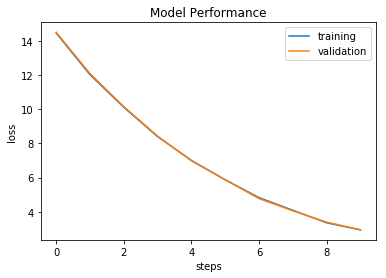

In [22]:
plt.plot(np.squeeze(all_train_loss),label='training')
plt.plot(np.squeeze(all_val_loss),label='validation')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Model Performance')
plt.legend()
plt.show()

In [24]:
siamese_predictions,accuracy = one_shot_testing(X_ost,Y_ost,"siamese_network",sess)
print("Accuracy of the siamese network",accuracy) # 20 way Test accuracy of one_shot_learning

Accuracy of the siamese network 58.5


### Visualizing predictions of the siamese network

We explore some of the output predictions made by the siamese network compared to the ground truth (test image) of the network.

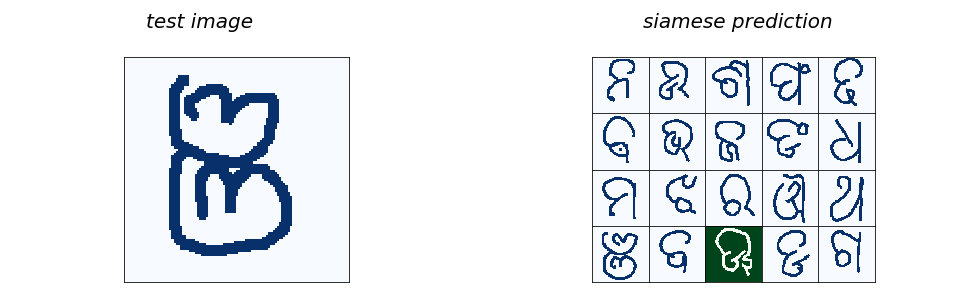

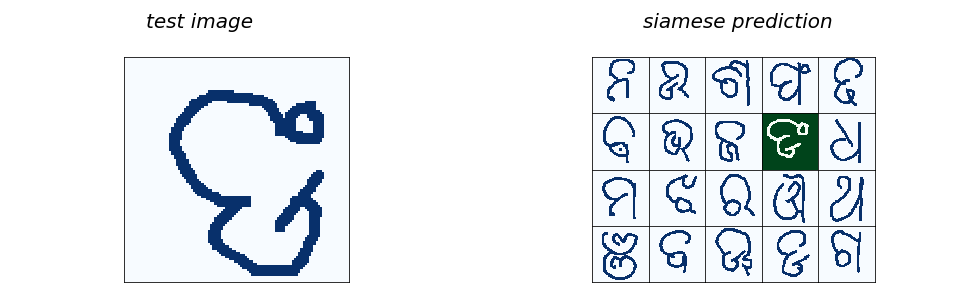

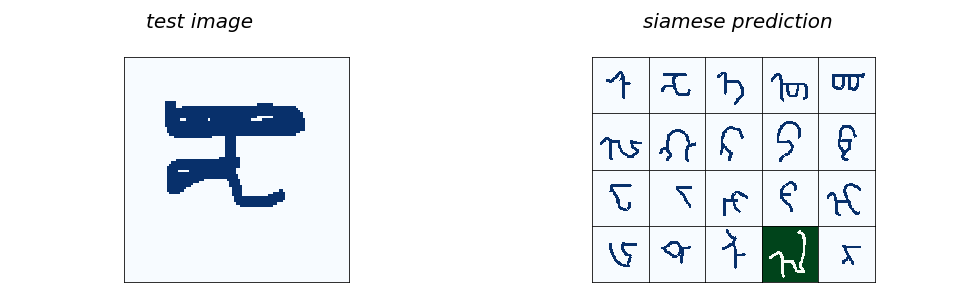

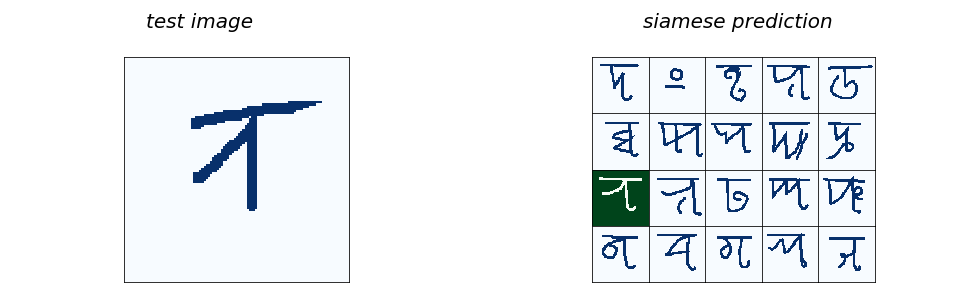

In [29]:
for _ in range(4):
    
    vec = []
    index = random.randint(0,len(X_ost)) 
    for im in X_ost[index]:
        vec.append(load_image(im,eval_folder))
        
    vec = iter(vec)
    text = iter(['test image','siamese prediction'])
    visualize_images(figsize=(17,5),
              text=text,
             inner1dim1=1,inner1dim2=1,inner2dim1=4,inner2dim2=5,img_paths_iter=vec,wspace=-0.75,prediction=siamese_predictions[index])
    

### Conclusion

Based on the results we can conclude that it performs considerably well compared to K-nn classifier even when trained for just few epochs. Also it is able to fit the train data and overfits a bit but still gives a descent score based on the complexity of the task. There are quite some differences between the 20 way one shot learning accuracy ~58% and the 2 way accuracy ~85% I believe the difference is because there are more classes to choose from and instead of predicting they are positive/negative pair we now have to choose the class sharing the most similarity. many characters share the common structures makinig it hard to get very good performance on unseen characters. Given that the accuracy is not even close when compared with the paper (~92%) Some of the reasons for it could be becuase
* Not having trained the model for long enough. 
* Some hypterparameters need to be tuned. (learning rate, regularization coeffs).
* the paper also introduces different momentum parameters and different learning rates for each layer and a learning rate decay of 0.1 throughout the network which is not used in my approach.
* The paper uses 150,000 samples to train the siamese network compared to 30,000 samples used in this notebook.
* The paper also uses data augmentation techniques to introduce images with affine distortions to improve performance which is not explored in this notebook.
* The paper uses bayesian optimization for tuning the hyperparameters which is not in the scope of this notebook.

The idea of this notebook is to show how one-shot learning task can be formulated and solved. The results of this notebook can be improved by following the procedures listed above.